# Demand Prediction 
## DSE203
## Machine Learning Team

### We've previously shown 4 supercategories. We'll make a regression model for each category.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load the data

In [2]:
import pandas as pd

In [100]:
sc = 1
df = pd.read_csv('ML_feat_cat{}.csv'.format(sc))
df = df.drop(df.columns[0], axis=1)

In [101]:
df.head()

,nodeid,mon,yr,total_sales_volume,total_sales_price,pm_total_sales_volume,pm_total_sales_price,l3m_total_sales_volume,l3m_total_sales_price,l12m_total_sales_volume,l12m_total_sales_price,numreviews_by_period,avgrating_by_period,numreviews,avgrating
0,2950,2.0,2012.0,12,123.65,22,229.93,130,1298.76,1327,14450.32,0.0,0.0,7.0,3.57
1,2950,2.0,2013.0,9,99.31,10,119.88,76,889.71,275,3054.69,0.0,0.0,7.0,3.57
2,2950,2.0,2014.0,5,49.22,0,0.00,86,1000.91,194,1530.04,0.0,0.0,7.0,3.57
3,2950,2.0,2015.0,2,12.95,4,404.65,18,739.62,72,2347.85,0.0,0.0,7.0,3.57
4,2950,2.0,2016.0,1,175.50,1,11.77,8,90.19,82,1398.90,0.0,0.0,7.0,3.57


## Sort the values by year then month so that we can use walk forward cross-validation

In [102]:
# Sort by date and time
df = df.sort_values(['yr', 'mon'])

## Don't trust data on the end years

The data has come back without nulls. So 0 and null are mixed. We think the 0's in the last year of the data are actually null (unknown) so it would be wrong to predict them as 0.

In [103]:
df = df[df['yr'] != df['yr'].max()]

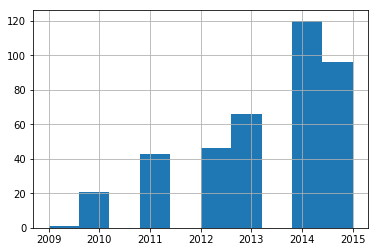

In [137]:
df['yr'].hist();

In [104]:
features = df.iloc[:, 5:]
features['month'] = df.iloc[:,1]

predictions = df.iloc[:,3]

In [105]:
y_log_tr = predictions.apply(lambda el: 0 if el == 0 else np.log10(el))

In [106]:
features_np = features.as_matrix()
predictions_np =y_log_tr.as_matrix()

In [107]:

num_test = df.shape[0]//3
X_train = features.iloc[:-num_test,:]
y_train = y_log_tr.iloc[:-num_test]
X_test = features.iloc[-num_test:,:]
y_test = y_log_tr.iloc[-num_test:]


# Fit the model to the training data

Here we use Gradient Boosted Regression trees with a max tree depth of 4 and minimum samples in a leaf for a split of 2. The learning rate is 0.01. 

There is a parameter called 'init' which is supposed to pass in any previously-trained regression model. The idea is that every time we train the model, then we can use the previously trained model as the starting point for the new model. Therefore, the only data we need to access is the data that was not included in the previous models. This will greatly help in scalability of the system. NOTE: There seems to be some current bug in sklearn for this. I believe XGBoost has the same procedure for performing online, batch updates of the regression model.

In [108]:
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

In [109]:
# params = {'n_estimators': [500,1000,2000,3000,4000,5000], 'max_depth': [2,3,4,5,10], 'min_samples_split': [2],
#            'max_features' : ['auto', 'sqrt', 'log2'],
#           'learning_rate': [0.001, 0.002, 0.005, 0.01, 0.02, 0.05], 'loss': ['huber']}

params = {'n_estimators': [500,3000,5000], 'max_depth': [2,4], 'min_samples_split': [2],
           'max_features' : ['auto', 'sqrt', 'log2'],
          'learning_rate': [0.001, 0.005, 0.01], 'loss': ['huber']}

clf = ensemble.GradientBoostingRegressor()

grid_search_GBR = GridSearchCV(clf, params)
# if sc == 1:
#     params = params1
# elif sc == 2:
#     params = params2

In [110]:

num_test = df.shape[0]//3
X_train = features.iloc[:-num_test,:]
y_train = y_log_tr.iloc[:-num_test]
X_test = features.iloc[-num_test:,:]
y_test = y_log_tr.iloc[-num_test:]


In [111]:
grid_search_GBR.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [500, 3000, 5000], 'max_depth': [2, 4], 'min_samples_split': [2], 'max_features': ['auto', 'sqrt', 'log2'], 'learning_rate': [0.001, 0.005, 0.01], 'loss': ['huber']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [113]:
grid_search_GBR.best_score_

0.62189822853046794

In [114]:
grid_search_GBR.best_params_

{'learning_rate': 0.005,
 'loss': 'huber',
 'max_depth': 2,
 'max_features': 'log2',
 'min_samples_split': 2,
 'n_estimators': 3000}

In [130]:
params1 = {'learning_rate': 0.005, 'loss': 'huber',
 'max_depth': 2, 'max_features': 'log2', 'min_samples_split': 2,
 'n_estimators': 1500}

params2 = {'learning_rate': 0.01, 'loss': 'huber', 'max_depth': 4, 
           'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}

if (sc==1):
        params = params1
elif (sc==2):
    params = params2
clf = ensemble.GradientBoostingRegressor(**params)

In [142]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

In [141]:

for train_index, test_index in tscv.split(features_np):
    
    X_train, X_test = features_np[train_index], features_np[test_index]
    y_train, y_test = predictions_np[train_index], predictions_np[test_index]
    
    clf.fit(X_train, y_train)
    
    print(clf.score(X_test, y_test))

0.541744179324
0.664213979355
0.538761022643


# Evaluate the model against the test data

In [147]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

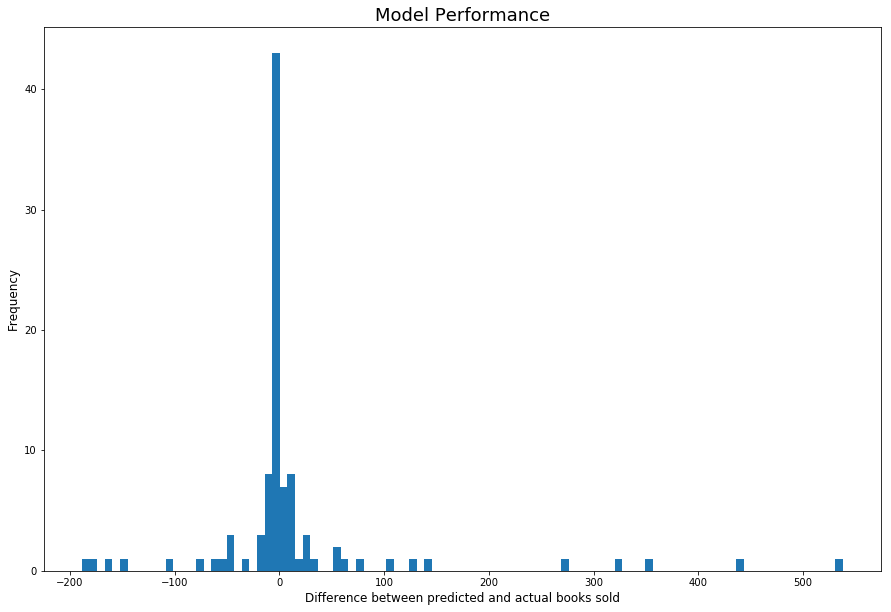

In [185]:
plt.figure(figsize=(15,10))
plt.hist(10**y_test-10**y_hat, bins=100);
plt.title('Model Performance', fontsize=18);
plt.xlabel('Difference between predicted and actual books sold', fontsize=12);
plt.ylabel('Frequency', fontsize=12);

Explained variance = 0.572
Mean squared error = 0.2906
Mean absolute error = 2.9258
r-squared = 0.539


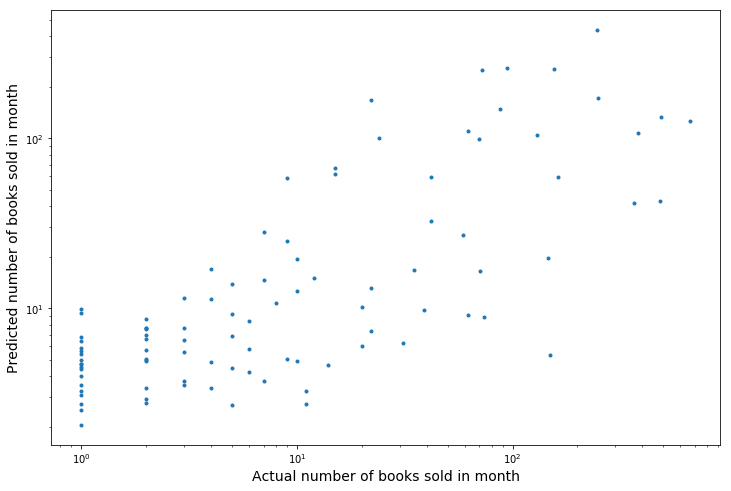

In [159]:
y_hat = clf.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
mae = mean_absolute_error(y_test, y_hat)

plt.figure(figsize=(12,8))
plt.loglog(10**y_test, 10**y_hat, '.')
plt.xlabel('Actual number of books sold in month', fontsize=14)
plt.ylabel('Predicted number of books sold in month', fontsize=14)
print('Explained variance = {:.3f}'.format(explained_variance_score(y_test, y_hat)))
print('Mean squared error = {:.4f}'.format(mse))
print('Mean absolute error = {:.4f}'.format(10**mae))
print('r-squared = {:.3f}'.format(clf.score(X_test, y_test)))

# Training and Testing Mean Squared Error as a function of Iteration

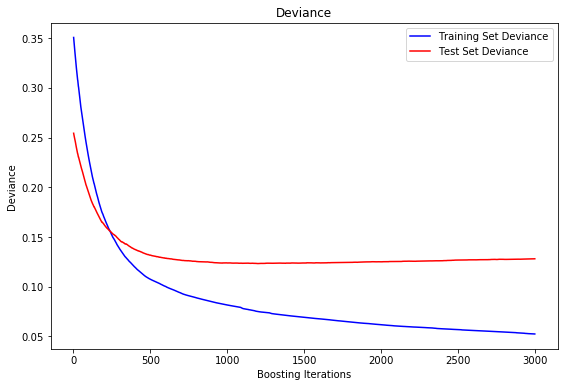

In [121]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance');

# Relative Importance of Different Features

This approach will allow us to weight the relative importance of different features to the regression.  This will help us to explain the model to the client in relatively simple terms. For example, we can say things like "The important features to predicting the number of sales are price, recent sentiment about the book, and the last 4 months of sales."

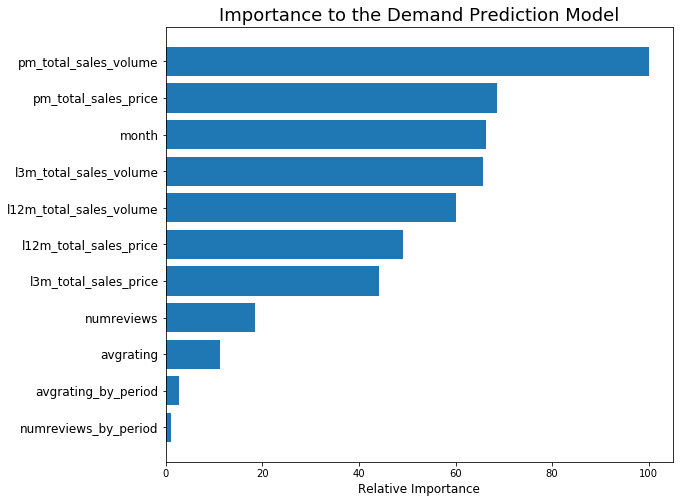

In [93]:

feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(20,8))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')

labels = features.columns

plt.yticks(pos, labels[sorted_idx], fontsize=12)
plt.xlabel('Relative Importance', fontsize=12)
plt.title('Importance to the Demand Prediction Model', fontsize=18)
plt.show()

In [143]:
features.shape

(393, 11)